In this problem, you will train a neural network to classify satellite images. In the data/EuroSAT_RGB directory, you will find 11 subdirectories, each corresponding to a different class of land or land use: e.g. industrial, crops, rivers, forest, etc. Within each subdirectory, you will find examples in .jpg format of each type. (Thus the name of the directory in which the image lives is the class label.)

Your job is to set up a neural network that can classify the images as accurately as possible. Use an 80/20 train test split. Summarize your model and its accuracy in any way you see fit, but make you include at a minimum the following elements:

overall test-set accuracy, measured however you think is appropriate
show some of the example images from the test set, together with your model's predicted classes.
a confusion matrix showing the performance of the model on the set test, i.e. a table that cross-tabulates each test set example by (actual class, predicted class).
I strongly recommend the use of PyTorch in a Jupyter notebook for this problem; look into PyTorch's ImageFolder data set class, which will streamline things considerably.


In [29]:
import torch
import torchvision.transforms as transforms
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import ImageFolder
from efficientnet_pytorch import EfficientNet
import torch.nn.functional as F

In [30]:
path = "EuroSAT_RGB"
data = ImageFolder(root=path, transform=transform)

In [31]:
#Convert to Tensor and Normalize for RGB
transform = transforms.Compose([
    transforms.ToTensor(),                
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  
])

# Split dataset into train and test
train_size = int(0.8 * len(data))
test_size = len(data) - train_size
train_set, test_set = random_split(data, [train_size, test_size])

batch_size = 64
trainloader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=2)
testloader = DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=2)


In [32]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, 1)   # Update input channels to 3 for RGB
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout2d(0.25)
        self.dropout2 = nn.Dropout2d(0.5)
        self.fc1 = nn.Linear(57600, 128)  # Update input features based on 64x64 RGB image
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)
net = Net()

In [33]:
# Set the device to GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters())

In [34]:
# Train our model using CNN : 10 epochs
num_epochs = 10
for epoch in range(num_epochs):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        if i % 100 == 99:  # Print every 100 mini-batches
            print(f"[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 100:.3f}")
            running_loss = 0.0

print("Finished Training")

/Users/mansi/anaconda3/lib/python3.11/site-packages/torch/nn/functional.py:1331: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


[1,   100] loss: 1.654
[1,   200] loss: 1.265
[1,   300] loss: 1.129
[2,   100] loss: 0.999
[2,   200] loss: 0.943
[2,   300] loss: 0.878
[3,   100] loss: 0.790
[3,   200] loss: 0.783
[3,   300] loss: 0.804
[4,   100] loss: 0.678
[4,   200] loss: 0.674
[4,   300] loss: 0.657
[5,   100] loss: 0.580
[5,   200] loss: 0.607
[5,   300] loss: 0.553
[6,   100] loss: 0.530
[6,   200] loss: 0.542
[6,   300] loss: 0.489
[7,   100] loss: 0.454
[7,   200] loss: 0.477
[7,   300] loss: 0.463
[8,   100] loss: 0.411
[8,   200] loss: 0.416
[8,   300] loss: 0.386
[9,   100] loss: 0.353
[9,   200] loss: 0.374
[9,   300] loss: 0.370
[10,   100] loss: 0.312
[10,   200] loss: 0.328
[10,   300] loss: 0.346
Finished Training


In [37]:
#Check test set accuracy 
net.eval()

correct = 0
total = 0
predicted_labels = []
true_labels = []

with torch.no_grad():
    for data in testloader:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = net(inputs)
        _, predicted = torch.max(outputs.data, 1)
        
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        predicted_labels.extend(predicted.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

accuracy = 100 * correct / total
print("Accuracy on test set: {:.2f}%".format(accuracy))


Accuracy on test set: 84.76%


/Users/mansi/anaconda3/lib/python3.11/site-packages/torch/nn/functional.py:1331: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


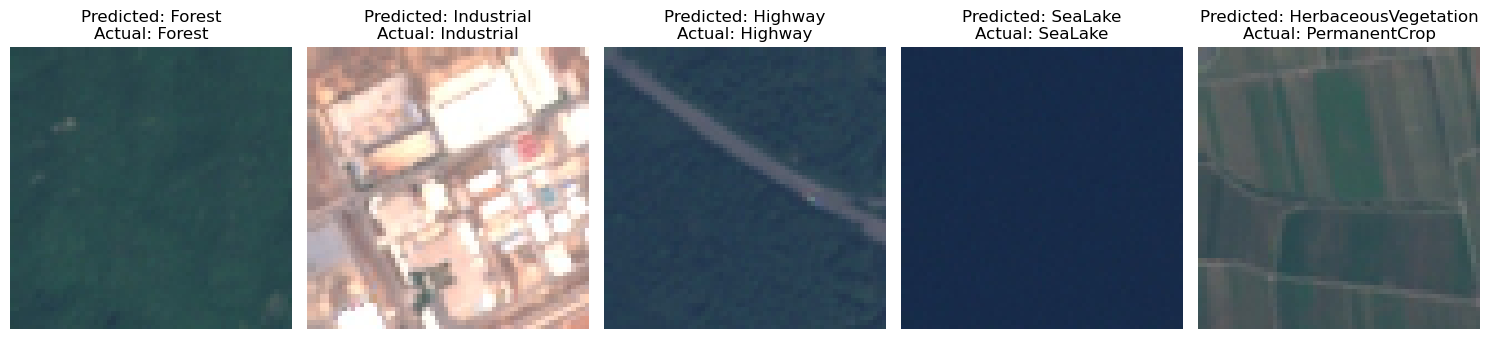

In [43]:
import numpy as np
import matplotlib.pyplot as plt
import torchvision.transforms as transforms

# Visualize some test images along with predicted and actual labels
num_images_to_show = 5
indices = np.random.choice(len(test_set), num_images_to_show, replace=False)

# Transformation to convert tensors to PIL images
to_pil = transforms.Compose([
    transforms.Normalize(mean=[-0.5 / 0.5, -0.5 / 0.5, -0.5 / 0.5], std=[1 / 0.5, 1 / 0.5, 1 / 0.5]),
    transforms.ToPILImage()
])

plt.figure(figsize=(15, 10))
net.eval()  # Set the model to evaluation mode
with torch.no_grad():
    for i, idx in enumerate(indices):
        image, label = test_set[idx]
        
        # Move image to the appropriate device
        image = image.unsqueeze(0).to(device)
        
        # Get the predicted label from your model
        outputs = net(image)
        _, predicted_label = torch.max(outputs, 1)
        predicted_label = predicted_label.item()
        
        # Convert tensor back to PIL image
        pil_image = to_pil(image[0].cpu())
        
        ax = plt.subplot(1, num_images_to_show, i + 1)
        ax.imshow(pil_image)
        ax.set_title(f"Predicted: {test_set.dataset.classes[predicted_label]}\nActual: {test_set.dataset.classes[label]}")
        ax.axis("off")

plt.tight_layout()
plt.show()

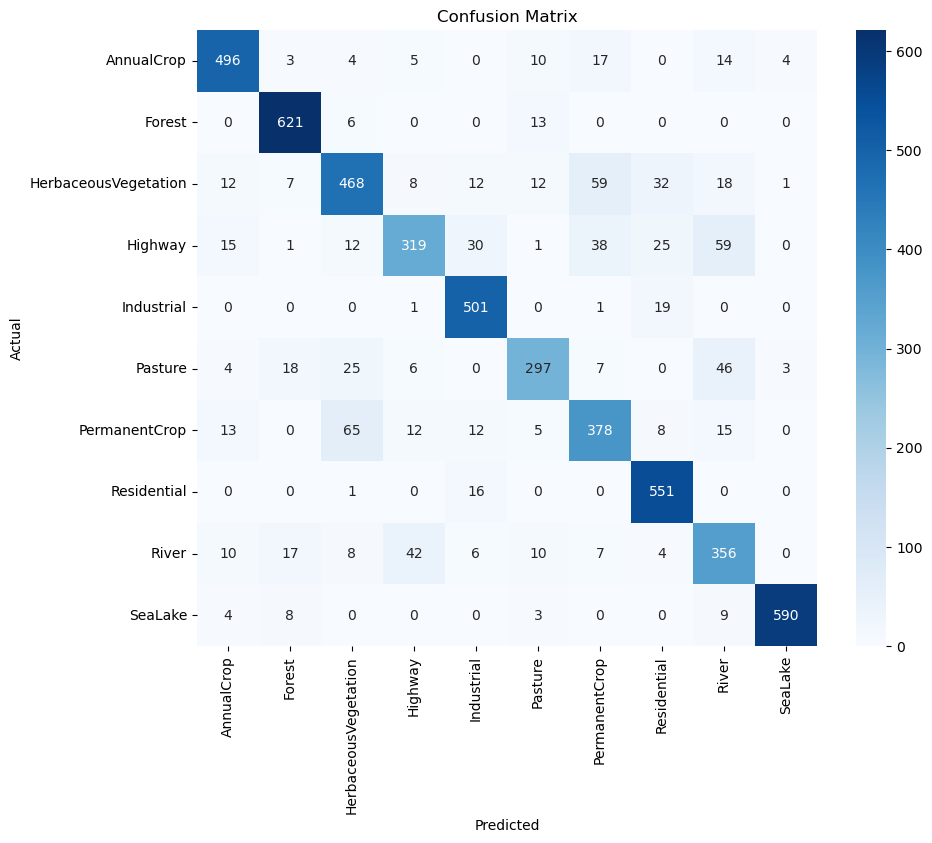

In [42]:
from sklearn.metrics import confusion_matrix
import seaborn as sns


# Build the confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=test_set.dataset.classes, yticklabels=test_set.dataset.classes)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

**Our Basic CNN Performance:**

We have developed a basic Convolutional Neural Network (CNN) model for image classification using 10 epochs and attained an accuracy of 84.7%. 

It is worth noting that we can try other other classification methods like ResNet or AlexNet, which could have provided better accuracy due to the model's ability ot capture high level features and patterns from diverse data, hence optimising image classification.